In [177]:
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate, iradon, iradon_sart
import cv2
import numpy as np
from tqdm import tqdm
import polars as pl
import numpy as np

## Sphere

In [178]:
_pth = r'F:\EPID Images\sphere\854320165'
# _pth = r'F:\EPID Images\2024-05-04 17-12-18-MV Dosimetry-6x_Patient 1_Arc CW\854320170'
_files = os.listdir(_pth)

In [179]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

In [180]:
_time = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    _time.append(raw.RTImageLabel)

100%|██████████| 412/412 [00:01<00:00, 266.10it/s]


## Checking if all of them are in order

In [181]:
newdata = np.array([x.split('-')[1] for x in _time])


## Stacking images into IMG (ixnxm) matrix where i is the i^th image

In [182]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.uint16)
curr = np.zeros((shape[0], shape[0]), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    _m = curr - prev
    
    if np.max(_m) > 10000:
        _images[idx, :, :] = _images[idx-1, :, :]
        g_angle.append(g_angle[idx-1])
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)
        
    prev = curr


100%|██████████| 412/412 [00:02<00:00, 139.82it/s]


## unsorted sinograms

In [196]:
_ = np.linspace(-1, 1, _images[0].shape[0])
g_angle = np.array(g_angle)
thetas = np.array(g_angle)
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
p = np.array([rotation.sum(axis=0)*dr for rotation in _images]).T

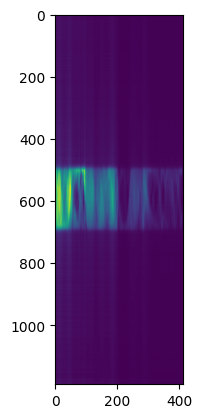

In [197]:
plt.imshow(p)

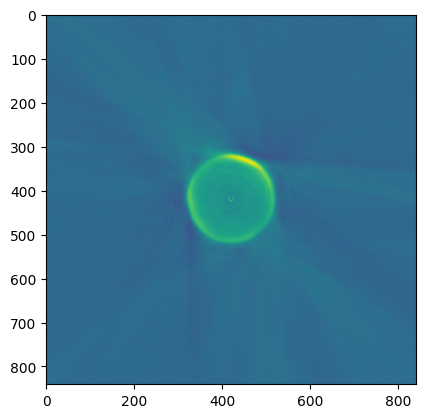

: 

In [201]:
reconstructed_slice = iradon(p,theta=thetas, circle=False, filter_name='ramp')
plt.imshow(reconstructed_slice)

In [186]:
np.max(reconstructed_slice)

1.6935026598302831

## Sorted sinograms

In [187]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)

for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]

100%|██████████| 412/412 [00:00<00:00, 1085.13it/s]


In [188]:
def normalize_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    normalized_image = (image - img_min) / (img_max - img_min)
    return normalized_image

In [189]:
g_angle2 = g_angle[sorted_inx]
thetas = np.array(g_angle2)
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
sp = np.array([rotation.sum(axis=0)*dr for rotation in sorted_images]).T

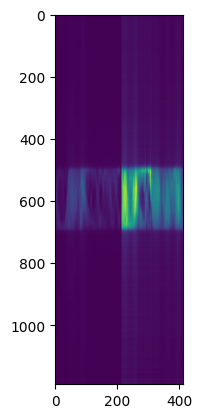

In [190]:
plt.imshow(sp)

Text(0.5, 1.0, 'Gantry Angle (sorted)')

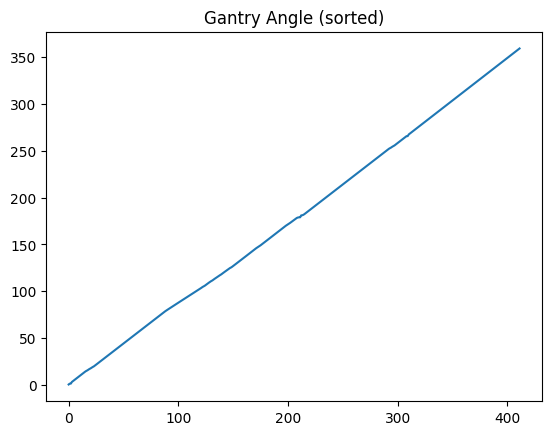

In [191]:
plt.plot(thetas)
plt.title('Gantry Angle (sorted)')

In [192]:
reconstructed_slice = iradon(sp, theta=thetas, circle=False,filter_name='ramp', output_size=512)
# plt.imshow(reconstructed_slice, cmap='rgb')

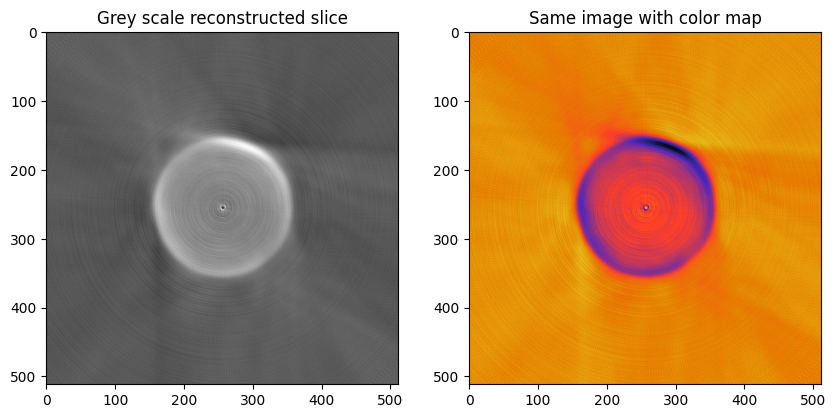

In [193]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot data on each subplot
ax1.imshow(reconstructed_slice, cmap='grey')
ax1.set_title('Grey scale reconstructed slice')

ax2.imshow(reconstructed_slice*10, cmap='CMRmap_r')
ax2.set_title('Same image with color map')

# Display the figure with subplots
plt.show()

## Sinograms with sorted theta

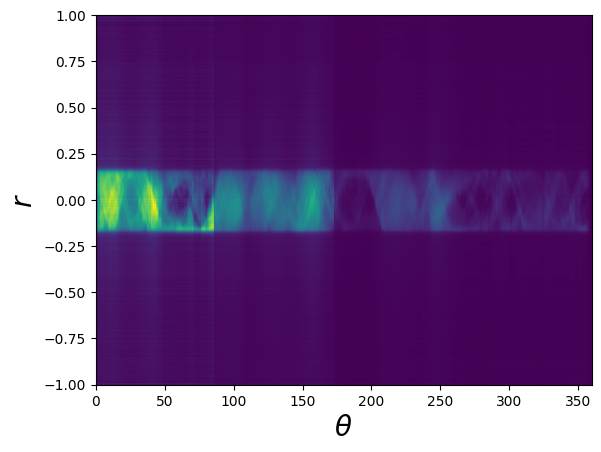

In [194]:
plt.pcolor(thetas, rs, p, shading='auto')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.show()